In [1]:
import pandas as pd
import seaborn as sns

df = pd.read_csv("Reviews.csv").set_index("Id")
df = df.sample(100000)

texts = df['Text'].tolist()

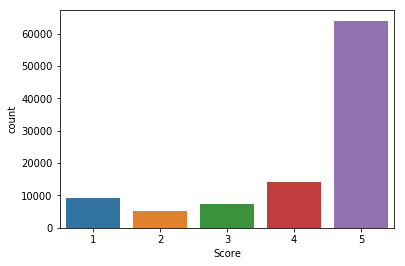

In [2]:
sns.countplot(df['Score'])

In [3]:
import numpy as np

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

MAX_NB_WORDS=20000
MAX_SEQUENCE_LENGTH=2048
VALIDATION_SPLIT = 0.2

tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = df['Score']
labels_index = {}
labels_index['test'] = 0
labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

Using TensorFlow backend.
c:\users\sbhen\appdata\local\programs\python\python36\lib\site-packages\keras_preprocessing\text.py:174: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 61570 unique tokens.
Shape of data tensor: (100000, 2048)
Shape of label tensor: (100000, 6)


In [4]:
import os

GLOVE_DIR = 'd:\workspaces\camp18'
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), mode='r', encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [5]:
EMBEDDING_DIM = 100

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [6]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [7]:
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, Flatten
from keras.models import Model

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(35)(x)  # global max pooling
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(6, activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

# happy learning!
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=2, batch_size=128)

Train on 80000 samples, validate on 20000 samples
Epoch 1/2
80000/80000 [==============================] - 406s 5ms/step - loss: 1.1446 - acc: 0.6373 - val_loss: 1.1213 - val_acc: 0.6440
Epoch 2/2
80000/80000 [==============================] - 404s 5ms/step - loss: 1.1291 - acc: 0.6388 - val_loss: 1.1234 - val_acc: 0.6442


In [8]:
history_df = pd.DataFrame(history.history)

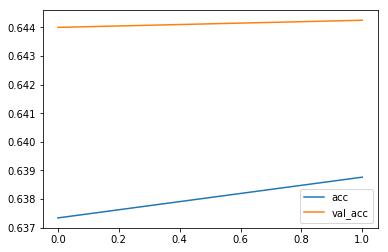

In [9]:
history_df[['acc', 'val_acc']].plot()